# 来自 bit.ly 的 1.usa.gov 的数据

In [6]:
from util.load_data import usaGovRecords

# 收集所有的时区信息
# 有些数据可能没有 tz 字段
# print([item['tz'] for item in usaGovRecords])
timeZone = [item['tz'] for item in usaGovRecords if 'tz' in item]

对时区进行计数，循环计数。
之后获取排名的前 n 个数据。

In [12]:
from collections import defaultdict

def get_count(sequence):
    counts = defaultdict(int)
    for item in sequence:
        counts[item] += 1
    return counts

def top_counts(count_dict, n=10):
    value_key_pairs = [(count, tz) for tz, count in count_dict.items()]
    value_key_pairs.sort()
    return value_key_pairs[-n:]

print(top_counts(get_count(timeZone)))

[(33, 'America/Sao_Paulo'), (35, 'Europe/Madrid'), (36, 'Pacific/Honolulu'), (37, 'Asia/Tokyo'), (74, 'Europe/London'), (191, 'America/Denver'), (382, 'America/Los_Angeles'), (400, 'America/Chicago'), (521, ''), (1251, 'America/New_York')]


In [13]:
from collections import Counter

counter = Counter(timeZone)

print(counter.most_common(10))

[('America/New_York', 1251), ('', 521), ('America/Chicago', 400), ('America/Los_Angeles', 382), ('America/Denver', 191), ('Europe/London', 74), ('Asia/Tokyo', 37), ('Pacific/Honolulu', 36), ('Europe/Madrid', 35), ('America/Sao_Paulo', 33)]


# 使用 pandas 对时区进行计数
DataFrame 是 pandas 中最重要的数据结构。

In [17]:
from pandas import DataFrame, Series
import pandas as pd
import numpy as np

frame = DataFrame(usaGovRecords)

print(frame)

                                                      a   c   nk   
0     Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...  US  1.0  \
1                                GoogleMaps/RochesterNY  US  0.0   
2     Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...  US  1.0   
3     Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8)...  BR  0.0   
4     Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...  US  0.0   
...                                                 ...  ..  ...   
3555  Mozilla/4.0 (compatible; MSIE 9.0; Windows NT ...  US  1.0   
3556  Mozilla/5.0 (Windows NT 5.1) AppleWebKit/535.1...  US  0.0   
3557                             GoogleMaps/RochesterNY  US  0.0   
3558                                     GoogleProducer  US  0.0   
3559  Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...  US  0.0   

                       tz  gr       g       h             l              al   
0        America/New_York  MA  A6qOVH  wfLQtf       orofrog  en-US,en;q=0.8  \
1          America/Denver

这里 frame 的输出形式是摘要视图，可以使用 frame['tz']返回 Series 对象的 value_counts 方法，获取所需要的信息。

In [19]:
tz_counts = frame['tz'].value_counts()

print(tz_counts[:10])

tz
America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: count, dtype: int64


我们可以利用绘图库(matplotlib)为数据生成一张图片，先给缺失和空的数据一个默认值。
fillna函数可以替换缺失值 (NA)，而未知值（空字符串）可以使用 bool 类型索引进行替换。

<Axes: ylabel='tz'>

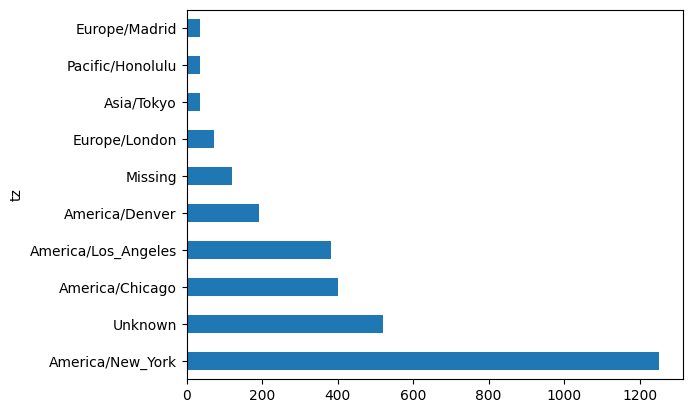

In [21]:
clean_tz = frame['tz'].fillna("Missing")
clean_tz[clean_tz == ''] = 'Unknown'
tz_counts = clean_tz.value_counts()

tz_counts[:10].plot(kind='barh', rot=0)

In [22]:
# 对数据处理下，只获取基本的浏览器信息。
results = Series([x.split()[0] for x in frame.a.dropna()])

print(results[:5])

0               Mozilla/5.0
1    GoogleMaps/RochesterNY
2               Mozilla/4.0
3               Mozilla/5.0
4               Mozilla/5.0
dtype: object


按 Windows 用户和非 Windows 用户对时区进行分解。如果 agent 字符串 Windows 就默认该用户为 Windows 用户。
np.where 就是三元运算符 x if condition else y 的向量版本。
例如：np.where([True, False], ['A1', 'A2'], ['B1', 'B2']) 的结果为 ['A1', 'B2']。

In [38]:
cframe = frame[frame.a.notnull()]

# str 可以跳过 NA 等数据为空的数值的判断
os = np.where(cframe['a'].str.contains('Windows'), 'Windows', 'Not Windows')

by_tz_os = cframe.groupby(['tz', os])

# size 对分组数据计数
# unstack 对数据进行重塑，A:[B1:1, B2:2] 调整为 A-B1:1, A-B2:2
agg_counts = by_tz_os.size().unstack().fillna(0)

agg_counts[:10]

,Not Windows,Windows
tz,,
,245.0,276.0
Africa/Cairo,0.0,3.0
Africa/Casablanca,0.0,1.0
Africa/Ceuta,0.0,2.0
Africa/Johannesburg,0.0,1.0
Africa/Lusaka,0.0,1.0
America/Anchorage,4.0,1.0
America/Argentina/Buenos_Aires,1.0,0.0
America/Argentina/Cordoba,0.0,1.0


分组完成的数据可以调用 sum(int) 进行求和，参数为求和字段的索引，例如上图数据中 0 代表对 tz 计数，1 代表对 Not Windows/Windows 计数。
argsort()函数返回对应值在原数据中的索引。

In [49]:
indexer = agg_counts.sum(1).argsort()

indexer[:10]

tz
                                  24
Africa/Cairo                      20
Africa/Casablanca                 21
Africa/Ceuta                      92
Africa/Johannesburg               87
Africa/Lusaka                     53
America/Anchorage                 54
America/Argentina/Buenos_Aires    57
America/Argentina/Cordoba         26
America/Argentina/Mendoza         55
dtype: int64

最后我们可以使用 take 按照这个索引获取最后10行。

In [50]:
# indexer 已经按时区总数进行排序了返回的数据索引。
# take 按索引进行重新获取数据。
count_subset = agg_counts.take(indexer)[-10:]

count_subset

,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


可以生成一张条形图，使用 stacked=True 生成堆积条形图。

<Axes: ylabel='tz'>

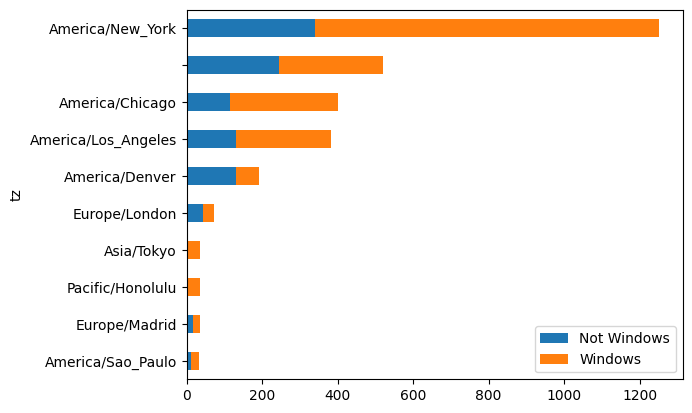

In [51]:
count_subset.plot(kind='barh', stacked=True)

数据太小看不清数据的比例，可以将其转换为百分比展示。各行规范化为数据为1的并重新绘图。

<Axes: ylabel='tz'>

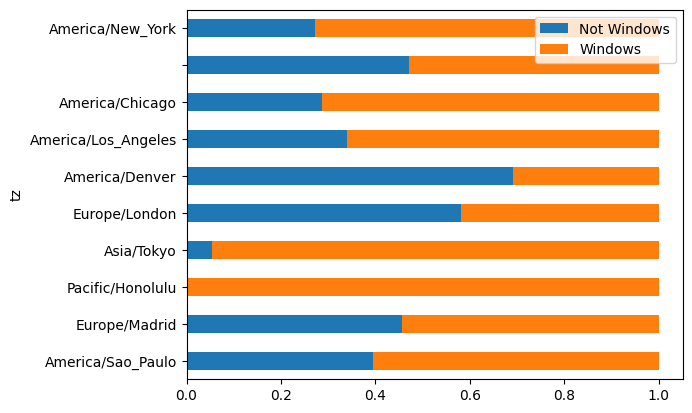

In [52]:
# Pandas dataframe.div() 用于查找数据帧和其他元素的浮点数划分。
normed_subset = count_subset.div(count_subset.sum(1), axis=0)
normed_subset.plot(kind='barh', stacked=True)

# movieLens 数据集

In [1]:
from  util.load_data import movieRatings, movies, movieUsers

from pandas import DataFrame, Series
import pandas as pd
import numpy as np

movieUsers[:5]

/Users/wttch/workspace/PG/PythonForDataAnalysis/util/load_data.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movieUsers = pd.read_table('data/movieLens/users.dat', sep='::', header=None, names=unames)
/Users/wttch/workspace/PG/PythonForDataAnalysis/util/load_data.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movieRatings = pd.read_table('data/movieLens/ratings.dat', sep='::', header=None, names=rnames)
/Users/wttch/workspace/PG/PythonForDataAnalysis/util/load_data.py:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators 

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [4]:
movieRatings[:5]

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
movies[:5]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
data = pd.merge(pd.merge(movieRatings, movieUsers), movies)

data

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...,...,...,...,...
1000204,5949,2198,5,958846401,M,18,17,47901,Modulations (1998),Documentary
1000205,5675,2703,3,976029116,M,35,14,30030,Broken Vessels (1998),Drama
1000206,5780,2845,1,958153068,M,18,17,92886,White Boys (1999),Drama
1000207,5851,3607,5,957756608,F,18,20,55410,One Little Indian (1973),Comedy|Drama|Western


使用 pivot_table 对数据进行聚合。

In [37]:
mean_ratings = data.pivot_table('rating', 'title', 'gender', aggfunc='mean')

mean_ratings[:5]

gender,F,M
title,,
"$1,000,000 Duck (1971)",3.375000,2.761905
'Night Mother (1986),3.388889,3.352941
'Til There Was You (1997),2.675676,2.733333
"'burbs, The (1989)",2.793478,2.962085
...And Justice for All (1979),3.828571,3.689024


根据电影 title 分组，然后利用 size 得到一个含有各电影分组大小的 Series。

In [9]:
ratings_by_title = data.groupby('title').size()

ratings_by_title[:10]

title
$1,000,000 Duck (1971)                37
'Night Mother (1986)                  70
'Til There Was You (1997)             52
'burbs, The (1989)                   303
...And Justice for All (1979)        199
1-900 (1994)                           2
10 Things I Hate About You (1999)    700
101 Dalmatians (1961)                565
101 Dalmatians (1996)                364
12 Angry Men (1957)                  616
dtype: int64

过滤评分不足 250 条的数据。

In [29]:
active_titles = ratings_by_title[ratings_by_title >= 250]

active_titles

title
'burbs, The (1989)                   303
10 Things I Hate About You (1999)    700
101 Dalmatians (1961)                565
101 Dalmatians (1996)                364
12 Angry Men (1957)                  616
                                    ... 
Young Guns (1988)                    562
Young Guns II (1990)                 369
Young Sherlock Holmes (1985)         379
Zero Effect (1998)                   301
eXistenZ (1999)                      410
Length: 1216, dtype: int64

In [38]:
mean_ratings = mean_ratings.loc[active_titles.keys()]

mean_ratings

gender,F,M
title,,
"'burbs, The (1989)",2.793478,2.962085
10 Things I Hate About You (1999),3.646552,3.311966
101 Dalmatians (1961),3.791444,3.500000
101 Dalmatians (1996),3.240000,2.911215
12 Angry Men (1957),4.184397,4.328421
...,...,...
Young Guns (1988),3.371795,3.425620
Young Guns II (1990),2.934783,2.904025
Young Sherlock Holmes (1985),3.514706,3.363344


为了了解女观众喜欢的电影，可以对 F 列降序处理。

In [39]:
top_female_ratings = mean_ratings.sort_values(by='F', ascending=False)

top_female_ratings

gender,F,M
title,,
"Close Shave, A (1995)",4.644444,4.473795
"Wrong Trousers, The (1993)",4.588235,4.478261
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.572650,4.464589
Wallace & Gromit: The Best of Aardman Animation (1996),4.563107,4.385075
Schindler's List (1993),4.562602,4.491415
...,...,...
"Avengers, The (1998)",1.915254,2.017467
Speed 2: Cruise Control (1997),1.906667,1.863014
Rocky V (1990),1.878788,2.132780


In [ ]:
## 计算评分分歧

In [40]:
mean_ratings['diff'] = mean_ratings['M'] - mean_ratings['F']

mean_ratings

gender,F,M,diff
title,,,
"'burbs, The (1989)",2.793478,2.962085,0.168607
10 Things I Hate About You (1999),3.646552,3.311966,-0.334586
101 Dalmatians (1961),3.791444,3.500000,-0.291444
101 Dalmatians (1996),3.240000,2.911215,-0.328785
12 Angry Men (1957),4.184397,4.328421,0.144024
...,...,...,...
Young Guns (1988),3.371795,3.425620,0.053825
Young Guns II (1990),2.934783,2.904025,-0.030758
Young Sherlock Holmes (1985),3.514706,3.363344,-0.151362


女性更喜欢的电影。

In [43]:
sorted_by_diff = mean_ratings.sort_values(by='diff')

sorted_by_diff

gender,F,M,diff
title,,,
Dirty Dancing (1987),3.790378,2.959596,-0.830782
Jumpin' Jack Flash (1986),3.254717,2.578358,-0.676359
Grease (1978),3.975265,3.367041,-0.608224
Little Women (1994),3.870588,3.321739,-0.548849
Steel Magnolias (1989),3.901734,3.365957,-0.535777
...,...,...,...
"Cable Guy, The (1996)",2.250000,2.863787,0.613787
"Longest Day, The (1962)",3.411765,4.031447,0.619682
Dumb & Dumber (1994),2.697987,3.336595,0.638608


男性更喜欢的电影。

In [44]:
sorted_by_diff[::-1][:15]

gender,F,M,diff
title,,,
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
Dumb & Dumber (1994),2.697987,3.336595,0.638608
"Longest Day, The (1962)",3.411765,4.031447,0.619682
"Cable Guy, The (1996)",2.250000,2.863787,0.613787
Evil Dead II (Dead By Dawn) (1987),3.297297,3.909283,0.611985
"Hidden, The (1987)",3.137931,3.745098,0.607167
Rocky III (1982),2.361702,2.943503,0.581801
Caddyshack (1980),3.396135,3.969737,0.573602


找出分歧最大点电影，使用方差。

In [52]:
rating_std_by_title = data.groupby('title')['rating'].std()

rating_std_by_title = rating_std_by_title.loc[active_titles.keys()]

rating_std_by_title.sort_values(ascending=False)

title
Dumb & Dumber (1994)                     1.321333
Blair Witch Project, The (1999)          1.316368
Natural Born Killers (1994)              1.307198
Tank Girl (1995)                         1.277695
Rocky Horror Picture Show, The (1975)    1.260177
                                           ...   
Wrong Trousers, The (1993)               0.708666
Shawshank Redemption, The (1994)         0.700443
Great Escape, The (1963)                 0.692585
Rear Window (1954)                       0.688946
Close Shave, A (1995)                    0.667143
Name: rating, Length: 1216, dtype: float64

对电影分类进行一次 split。

In [55]:
movies['category'] = movies['genres'].str.split('|')

movies

,movie_id,title,genres,category
0,1,Toy Story (1995),Animation|Children's|Comedy,"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),Adventure|Children's|Fantasy,"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama,"[Comedy, Drama]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]
...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,[Comedy]
3879,3949,Requiem for a Dream (2000),Drama,[Drama]
3880,3950,Tigerland (2000),Drama,[Drama]
3881,3951,Two Family House (2000),Drama,[Drama]
